## 0. Libarary 불러오기

In [1]:
import os, glob
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.models import resnet50, resnext50_32x4d, resnet18, resnext101_32x8d
import timm
import albumentations as A

from torchsummary import summary
import torch_optimizer as optim
from torchsampler import ImbalancedDatasetSampler
from catalyst.data import BalanceClassSampler

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from facenet_pytorch import MTCNN

In [2]:
%matplotlib inline 

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


## 1. 데이터셋 정의

In [4]:
# 학습 데이터셋 폴더 경로를 지정해주세요.
train_dir = '/opt/ml/input/data/train'
trainimage_dir = os.path.join(train_dir, 'images')

In [5]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [6]:
if os.path.isfile('mask_df.csv'):
    mask_df = pd.read_csv('mask_df.csv')
else:
    masks = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'incorrect_mask', 'normal']
    wears = ['Wear', 'Wear', 'Wear', 'Wear', 'Wear', 'Incorrect', 'Not Wear']
    mask_df = pd.DataFrame()
    for person in train_df.values:
        for mask, wear in zip(masks, wears):
            mask_df = mask_df.append(pd.Series(np.append(person, (mask, wear))), ignore_index=True)
    mask_df.columns = np.append(train_df.columns.values, ('mask', 'wear'))
    mask_df.to_csv('mask_df.csv', index=False)

In [7]:
if os.path.isfile('labeled_df.csv'):
    labeled_df = pd.read_csv('labeled_df.csv')
else:
    labeled_df = pd.DataFrame()
    for idx, person in mask_df.iterrows():
        gender = person['gender']
        gender = 0 if gender=='male' else 1

        age = person['age']
        if age >= 60.0:
            age = 2
        elif age >= 30.0:
            age = 1
        else:
            age = 0

        mask = person['wear']
        if mask == 'Wear':
            mask = 0
        elif mask == 'Incorrect':
            mask = 1
        else:
            mask = 2

        label = 6*mask + 3*gender + age
        labeled_df = labeled_df.append(pd.Series(np.append(person, label)), ignore_index=True)
    labeled_df.columns = np.append(mask_df.columns.values, 'label')
    labeled_df = labeled_df.astype({'label': int})
    labeled_df.to_csv('labeled_df.csv', index=False)

In [8]:
transform = transforms.Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
])

In [9]:
class TrainDataset(Dataset):
    def __init__(self, path, labeled_df, transform):
        super(TrainDataset).__init__()
        self.path = path
        self.labeled_df = labeled_df
        self.transform = transform
        
    def __getitem__(self, idx):
        full_path = os.path.join(self.path, self.labeled_df.iloc[idx]['path'])
        img_list = glob.glob(full_path + '/*')
        file_name = self.labeled_df.iloc[idx]['mask']
        try:
            image = Image.open(os.path.join(full_path, file_name+'.jpg'))
        except:
            try:
                image = Image.open(os.path.join(full_path, file_name+'.png'))
            except:
                image = Image.open(os.path.join(full_path, file_name+'.jpeg'))
                
                
        # mtcnn 적용
        #use_cuda = torch.cuda.is_available()
        #device = torch.device("cuda" if use_cuda else "cpu")
        #mtcnn = MTCNN(keep_all=True, device=device)
        mtcnn = MTCNN(keep_all=True)
        boxes, probs = mtcnn.detect(image)
        
        if not isinstance(boxes, np.ndarray):
            # 직접 crop
            image = image.crop([50, 100, 350, 400])
        
        # boexes size 확인
        else:
            xmin = int(boxes[0, 0])-30
            ymin = int(boxes[0, 1])-30
            xmax = int(boxes[0, 2])+30
            ymax = int(boxes[0, 3])+30
            
            width, height = image.size
            if xmin < 0: xmin = 0
            if ymin < 0: ymin = 0
            if xmax > width: xmax = width
            if ymax > height: ymax = height
            
            image = image.crop([xmin, ymin, xmax, ymax])
        
        if self.transform:
            image = self.transform(image)

        label = self.labeled_df.iloc[idx]['label']
        return image, label
    
    def __len__(self):
        return len(self.labeled_df)
    
    def get_labels(self):
        return self.labeled_df['label']

In [10]:
train_data = TrainDataset(trainimage_dir, labeled_df, transform)

In [11]:
train_loader = DataLoader(train_data, batch_size=64, num_workers=4, shuffle=True)

## 2. Model 불러오기

In [12]:
class EfficientNet_b3_dropout(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=num_classes, drop_rate=0.7)

    def forward(self, x):
        return self.model(x)

In [13]:
model = EfficientNet_b3_dropout(num_classes=18)

In [14]:
model_path = '/opt/ml/image-classification-level1-29/hrlee/baseline/model/dropout2/best.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

EfficientNet_b3_dropout(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SwishMe()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SwishMe()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SwishMe()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_runni

## 3. Confusion Matrix

In [15]:
model.eval()
targets_list = list()
preds_list = list()
for i, (images, targets) in enumerate(train_loader) : 
    images = images.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        scores = model(images)
        _, preds = scores.max(dim=1)

    targets_list.extend(targets.cpu())
    preds_list.extend(preds.cpu())

In [16]:
print(len(targets_list))
print(len(preds_list))

18900
18900


* effnet + dropout 0.7

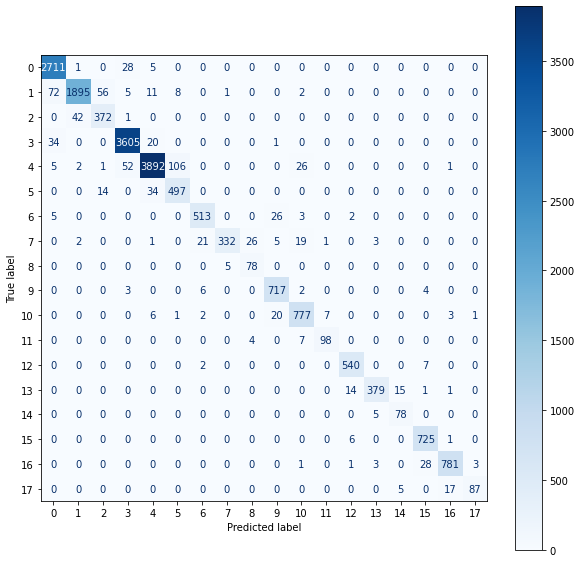

In [17]:
cm = confusion_matrix(targets_list, preds_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(18))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)

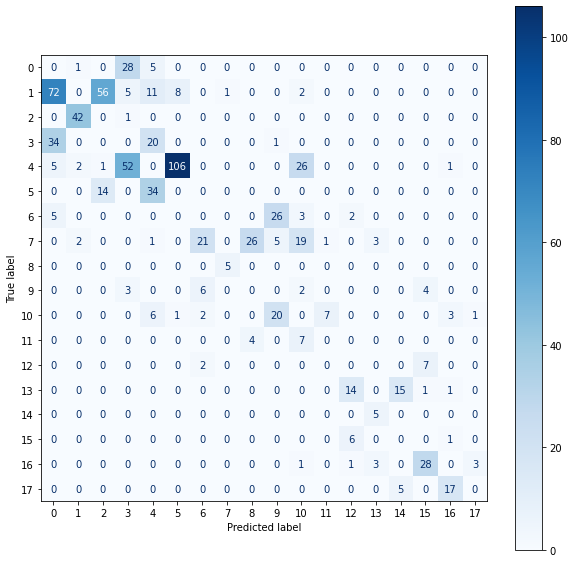

In [18]:
cm_nodiag = cm[:]
for i in range(len(cm_nodiag)):
    cm_nodiag[i][i] = 0
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nodiag, display_labels=range(18))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)